# Сегментация изображений на два класса

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import PIL
import numpy as np
from glob import glob
from scipy.cluster.vq import kmeans
import networkx as nx
import math

Populating the interactive namespace from numpy and matplotlib


In [2]:
def file_r(file, c):
        img_raw = PIL.Image.open(file)
        height, width = img_raw.size
        img_raw = img_raw.resize((round(height * c), round(width * c)), PIL.Image.ANTIALIAS)
        return np.array(img_raw)[:, :, :3].astype('int64')

In [3]:
#штраф за непохожесть на класс
def fine_1(c1, c2):
    return math.sqrt(((c1 - c2)**2).sum())

In [4]:
#штраф за отнесение соседних пикселей похожих цветов к разным классам
def fine_2(c1, c2):
    return 1.0 / (1.0 + fine_1(c1, c2) / 255.0)

In [5]:
def simple_cut(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if fine_1(img[x][y], centers[0]) < fine_2(img[x][y], centers[1]):
                classes[x][y] = 0
            else:
                classes[x][y] = 1
    return classes

In [6]:
#номер пикселя по координатам
def node_id(i, j, n):
    return n * i + j

In [7]:
#координаты пикселя по номеру
def pix_id_node(x, n):
    i = x // n
    j = x % n
    return i, j

In [8]:
def min_cut(img, centers, alpha, betta):
    #массив в котором к какому классу принадлежит пиксель
    classes = np.zeros_like(img[:, :, 0])
    
    #начинаем строить граф
    G = nx.DiGraph()
    n, m = img.shape[0], img.shape[1]
    
    #добавояем ребра
    for i in range(n):
        for j in range(m):
            #ребро вниз
            if i + 1 < n:
                G.add_edge(node_id(i, j, m), node_id(i + 1, j, m), capacity = betta * fine_2(img[i][j], img[i + 1][j]))
            #ребро вправо
            if j + 1 < m:
                G.add_edge(node_id(i, j, m), node_id(i, j + 1, m), capacity = betta * fine_2(img[i][j], img[i][j + 1]))
            #ребро вверх
            if i - 1 >= 0:
                G.add_edge(node_id(i, j, m), node_id(i - 1, j, m), capacity = betta * fine_2(img[i][j], img[i - 1][j]))
            #ребро влево
            if j - 1 >= 0:
                G.add_edge(node_id(i, j, m), node_id(i, j - 1, m), capacity = betta * fine_2(img[i][j], img[i][j - 1]))
            #ребра для штрафа 1-го типа
            G.add_edge(-1, node_id(i, j, m), capacity = alpha * fine_1(img[i][j], centers[1]))
            G.add_edge(node_id(i, j, m), -2, capacity = alpha * fine_1(img[i][j], centers[0]))
            
    #находим минимальный разрез
    min_cut_value, partition = nx.minimum_cut(G, -1, -2)
    
    
    for vertex in partition[0]:
        if vertex == -1:
            continue
        x, y = pix_id_node(vertex, m)
        classes[x][y] = 0
    
    for vertex in partition[1]:
        if vertex == -2:
            continue
        x, y = pix_id_node(vertex, m)
        classes[x][y] = 1
    
    return classes

In [9]:
#суммарный штраф сегментации равен сумме штрафов за каждый пиксель, умноженной на alpha,
#к которой прибавлена сумма штрафов за все пары пикселей, умноженная на beta
def get_penalty(img, classes, centers, alpha, betta):
    assert len(centers) == 2
    a = 0
    b = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            a += fine_1(img[x][y], centers[classes[x][y]])
            if x + 1 < img.shape[0]:
                if classes[x][y] != classes[x + 1][y]:
                    b += fine_2(img[x][y], img[x + 1][y])
            if y + 1 < img.shape[1]:
                if classes[x][y] != classes[x][y + 1]:
                    b += fine_2(img[x][y], img[x][y + 1])
            
    return alpha * a + betta * b

In [10]:
def simple_get_centers(img_file, compress=False):
    image = PIL.Image.open(img_file)
    h = image.size
    w = image.size
    if compress:
        image = image.resize((int(0.18 * h), int(0.18 * w)), PIL.Image.ANTIALIAS)
    img = np.array(image)[:, :, :3].astype('float').reshape((-1, 3))
    return kmeans(img.astype('float'), 2)[0].astype('int64')

In [11]:
#изображение по сегментации
def apply_cut(img, classes, centers):
    assert len(centers) == 2
    result = img // 4
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result[x][y] += centers[classes[x][y]]
    result = np.clip(result, 0, 255)
    return result

In [12]:
#обработка изображения
def process_img(img_file, cut_func, min_cut_func, centers, alpha, betta, c, show=False, show_penalty=False):
    img = file_r(img_file, c)
    centers = np.array(centers)
    
    #жадная сегментация
    classes = cut_func(img, centers)
    penalty = get_penalty(img, classes, centers, alpha, betta)
    clustered = apply_cut(img, classes, centers)
    
    #сегментация с минимальным разрезом
    mclasses = min_cut_func(img, centers, alpha, betta)
    mpenalty = get_penalty(img, mclasses, centers, alpha, betta)
    mclustered = apply_cut(img, mclasses, centers)
    
    
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(2, 2, 1)
        plt.imshow(img)

        fig.add_subplot(2, 2, 2)
        plt.imshow(clustered)
        
        fig.add_subplot(2, 2, 3)
        plt.imshow(mclustered)
        plt.show()
    
    if show_penalty:
        print(img_file)
        print('simple_cut %f' % penalty)
        print('min-cut %f' % mpenalty)
        print('diff %f' % (penalty - mpenalty))

    return penalty

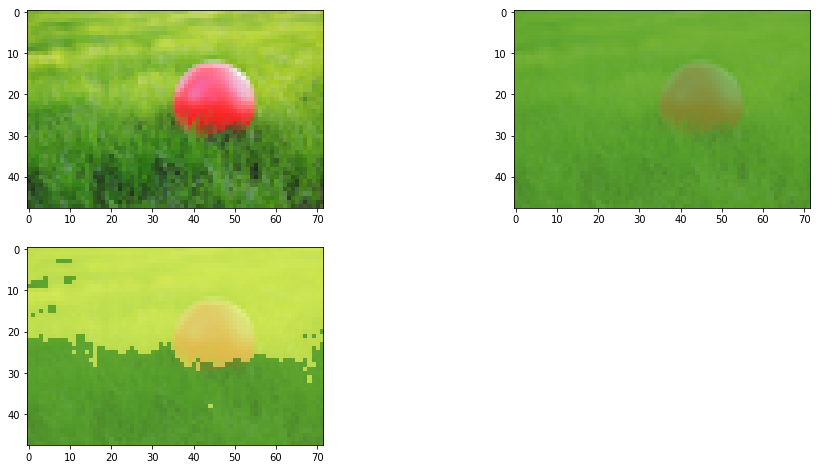

./imgs/ball.jpg
simple_cut 6733415.429184
min-cut 3346766.343295
diff 3386649.085889


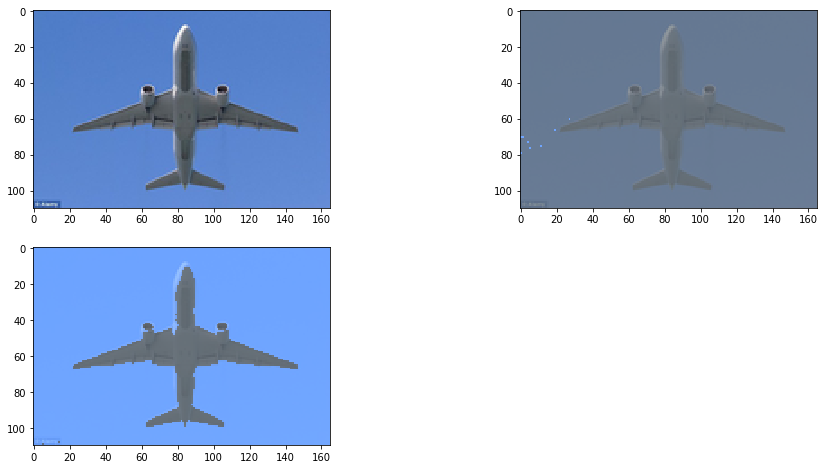

./imgs/plane.jpg
simple_cut 48041883.170068
min-cut 4738857.319347
diff 43303025.850721


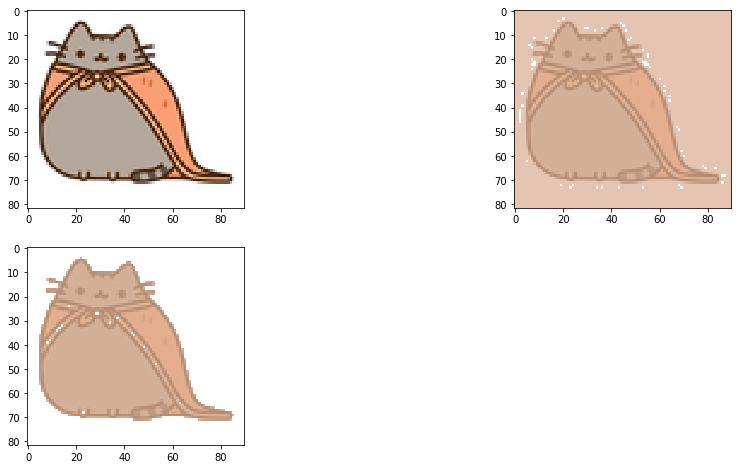

./imgs/cat.png
simple_cut 26678718.570610
min-cut 6963788.227303
diff 19714930.343308


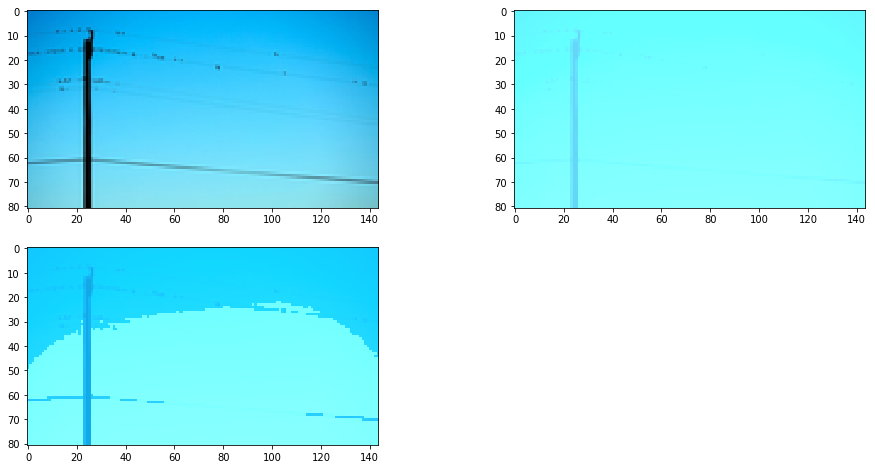

./imgs/sky.jpg
simple_cut 16325601.025586
min-cut 9340089.109039
diff 6985511.916547


In [13]:
alpha = 25.0
betta = 4.0

for img in glob('./imgs/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, min_cut, c, alpha, betta, 0.3, True, True)

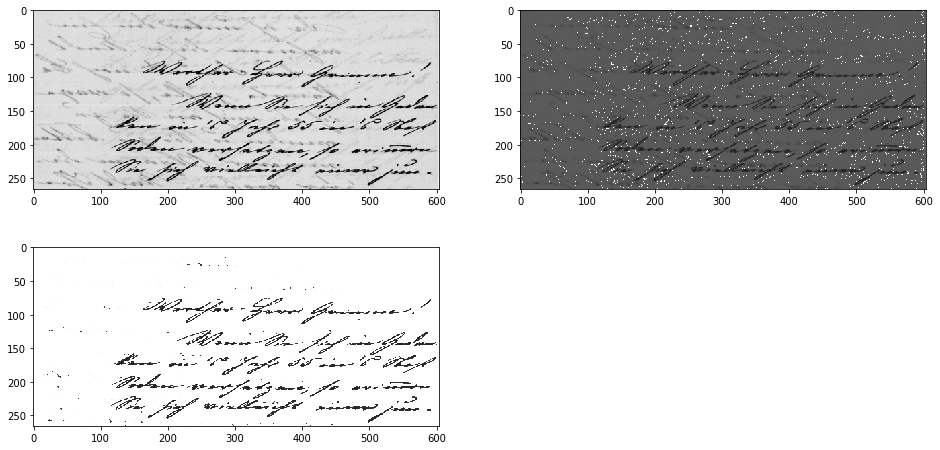

DIPCO2016_dataset/3.bmp
simple_cut 1157278394.609756
min-cut 82668709.085264
diff 1074609685.524491


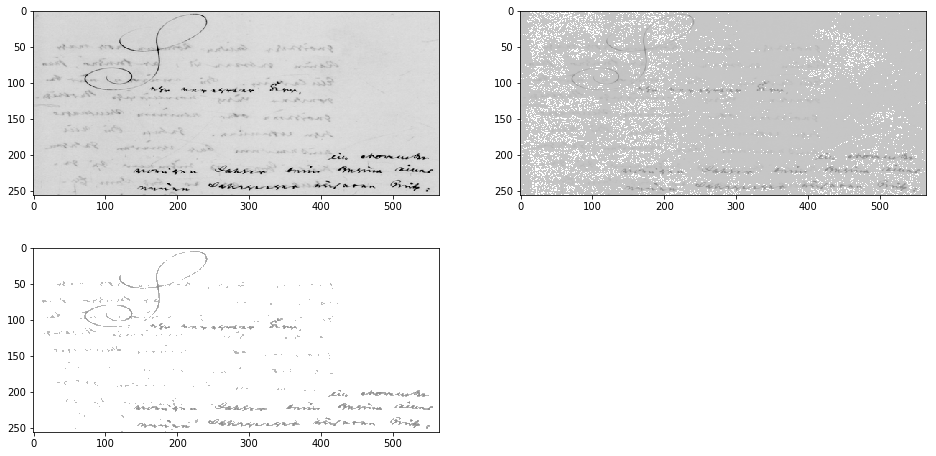

DIPCO2016_dataset/2.bmp
simple_cut 390718024.345644
min-cut 35107405.530138
diff 355610618.815506


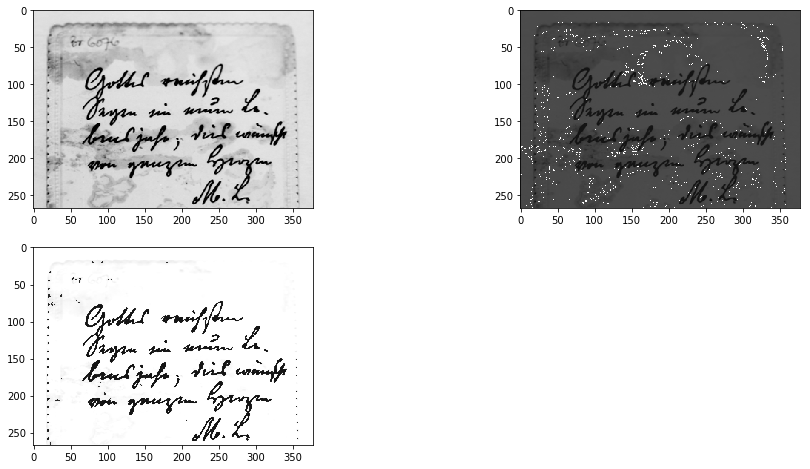

DIPCO2016_dataset/1.bmp
simple_cut 760716126.142928
min-cut 71729885.985286
diff 688986240.157642


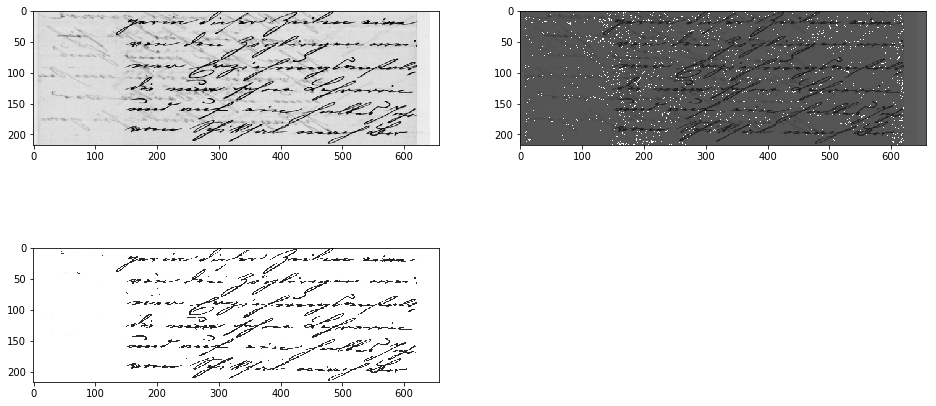

DIPCO2016_dataset/5.bmp
simple_cut 1041800001.614642
min-cut 83854083.372333
diff 957945918.242309


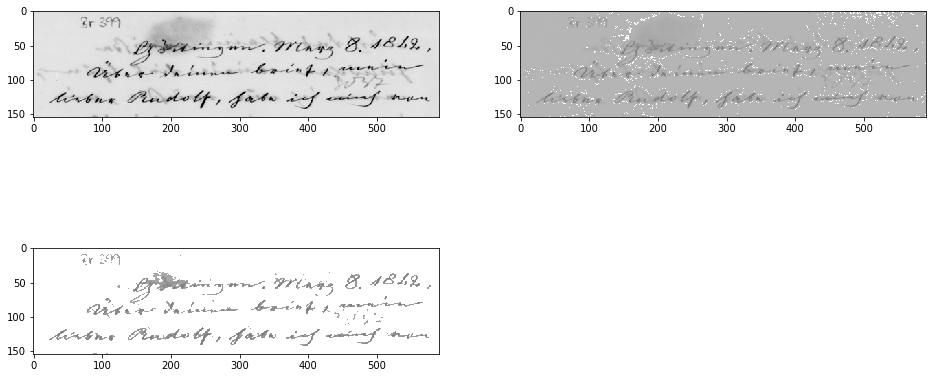

DIPCO2016_dataset/4.bmp
simple_cut 348501178.317743
min-cut 40335850.133953
diff 308165328.183790


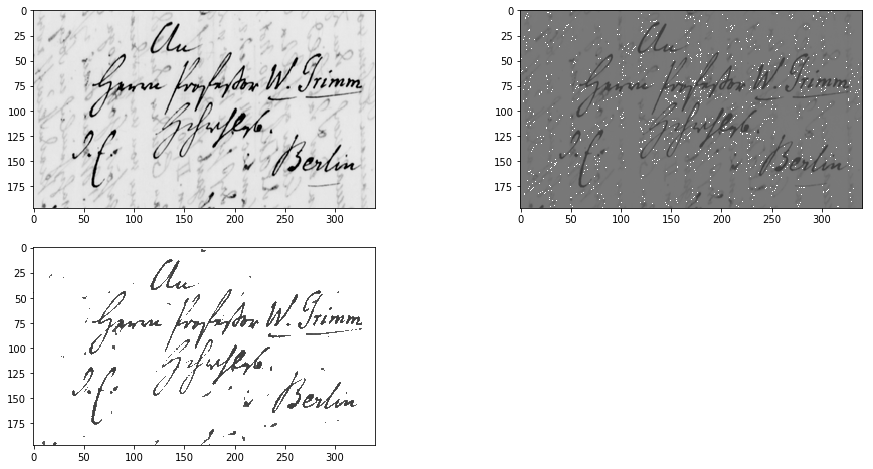

DIPCO2016_dataset/6.bmp
simple_cut 430494886.730574
min-cut 36072484.134166
diff 394422402.596409


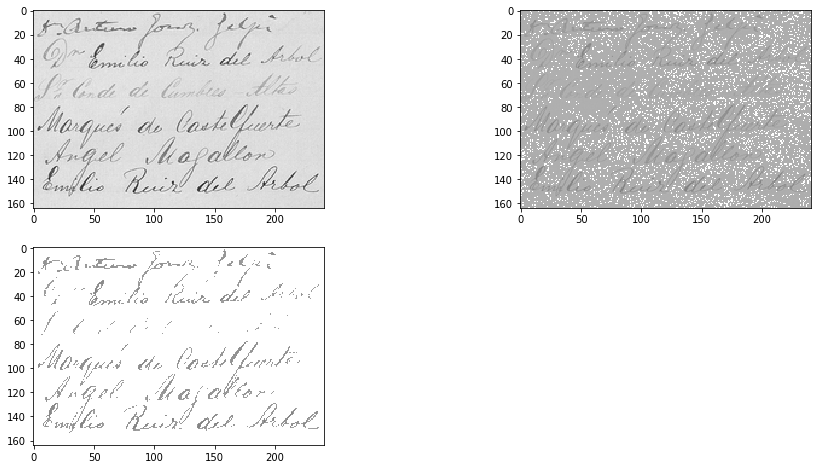

DIPCO2016_dataset/7.bmp
simple_cut 146655859.350637
min-cut 11705413.786020
diff 134950445.564618


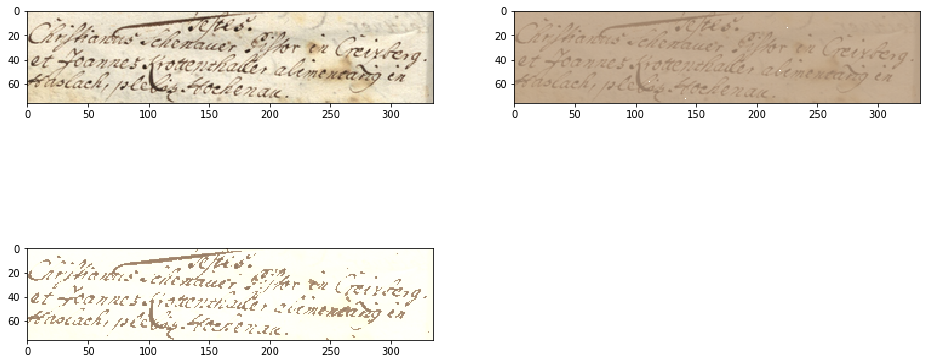

DIPCO2016_dataset/9.bmp
simple_cut 101282772.628834
min-cut 16656002.285274
diff 84626770.343560


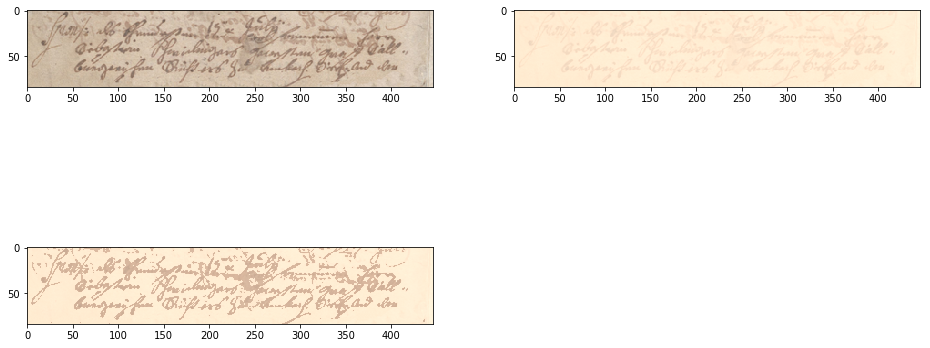

DIPCO2016_dataset/8.bmp
simple_cut 24912917.365223
min-cut 14244649.574491
diff 10668267.790732


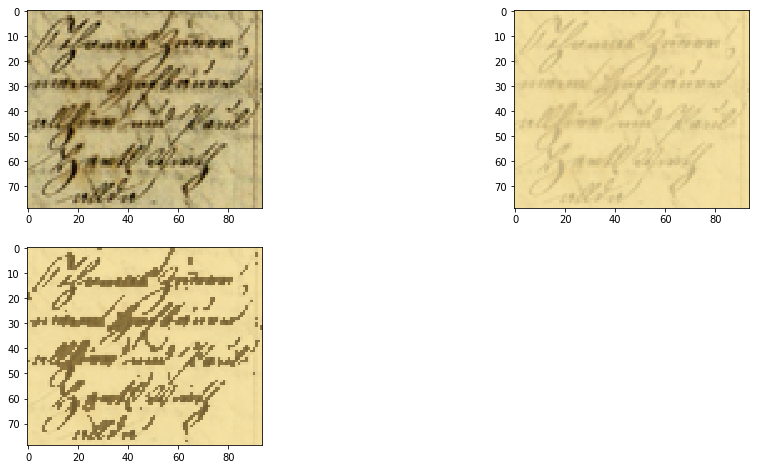

DIPCO2016_dataset/10.bmp
simple_cut 9015236.223705
min-cut 5088461.729304
diff 3926774.494401


In [14]:
for img in glob('DIPCO2016_dataset/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, min_cut, c, alpha, betta, 0.25, True, True)

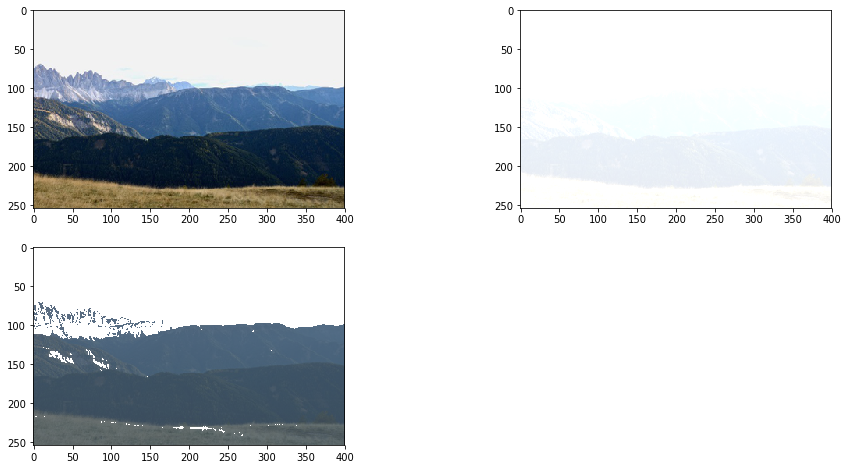

imgs_multicolor/landscape.jpg
simple_cut 447526888.945836
min-cut 142073680.684192
diff 305453208.261644


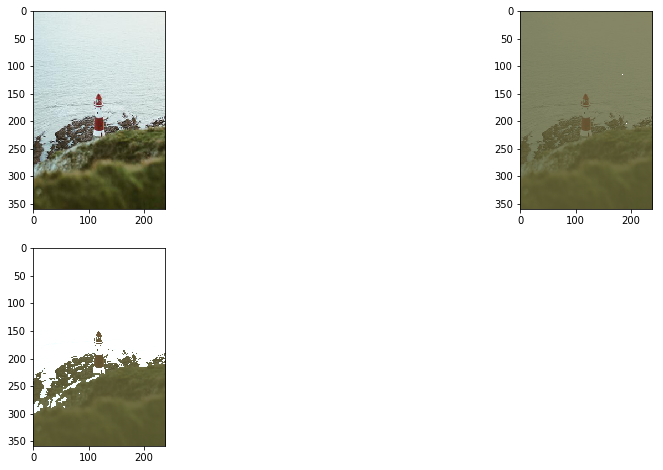

imgs_multicolor/beacon.jpg
simple_cut 378457473.646263
min-cut 58936585.122312
diff 319520888.523951


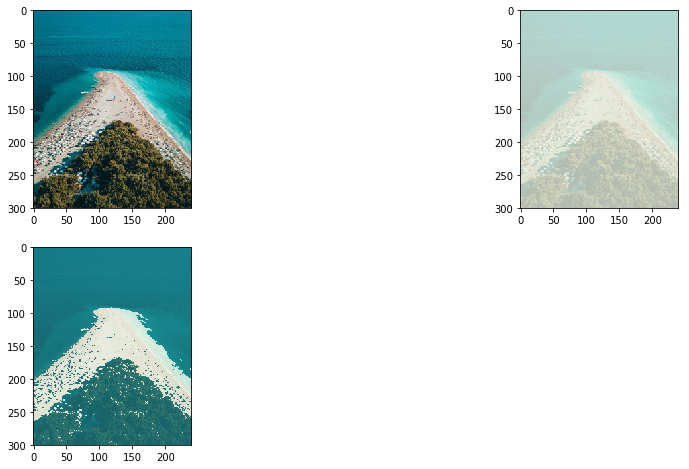

imgs_multicolor/coast.jpg
simple_cut 301763678.972508
min-cut 112694330.197329
diff 189069348.775179


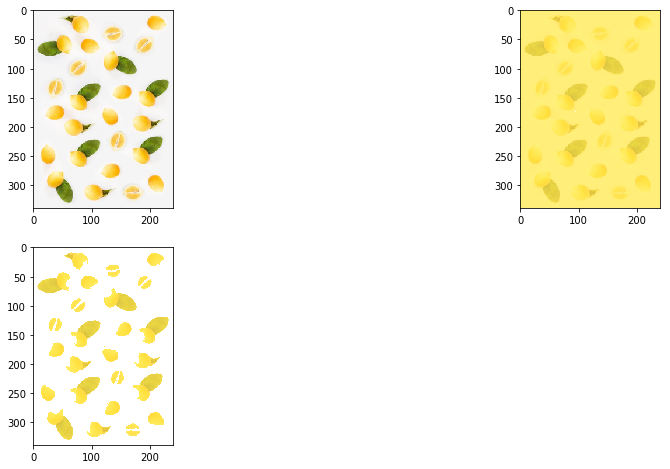

imgs_multicolor/lemons.jpg
simple_cut 343585046.343726
min-cut 56661091.405249
diff 286923954.938477


In [15]:
for img in glob('imgs_multicolor/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, min_cut, c, alpha, betta, 0.8, True, True)